#Post processing of T2m using linear regression and  neural network#

In this notebook, we postprocess T2m using the observed 2m temperature  TA and the ensemble means and sds of T2m, forecast temperature at 2m and other forecast variables from MEPS. We use linear regression and neural network based training. The loss function is CRPS. The codes are adapted from the paper Neural Networks for Postprocessing Ensemble Weather Forecasts by Rasp etal, 2018



In [0]:
%load_ext autoreload
%autoreload 2


In [0]:
%matplotlib inline
from matplotlib import pyplot
import pandas as pd
import numpy as np
import json
import io

In [0]:
# Imports
import sys

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Dropout, \
    SimpleRNN, LSTM, TimeDistributed, GRU, Dropout, Masking
from keras.layers.merge import Concatenate
from keras.models import Model, Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


## Data preparation. Download the file trdata_spatial_lcc_T2m_00+036.csv from googledrive. Find the ensemble means and sds of variables

In [0]:
# Code to read csv file into Colaboratory:
#https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = "https://drive.google.com/open?id=1-1MJtL-ZnmTWNLt6wSuxufNoQDnrOzdC"

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1-1MJtL-ZnmTWNLt6wSuxufNoQDnrOzdC


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('trdata_spatial_lcc_T2m_00+036.csv')  
df = pd.read_csv('trdata_spatial_lcc_T2m_00+036.csv')

In [0]:
dfsaved = df
df.head(2)

,LOC,TIME,TIME.REF,LT,SG.0,T2.0,T2.1,T2.2,T2.3,T2.4,T2.5,T2.6,T2.7,T2.8,T2.9,T0.0,T0.1,T0.2,T0.3,T0.4,T0.5,T0.6,T0.7,T0.8,T0.9,H2.0,H2.1,H2.2,H2.3,H2.4,H2.5,H2.6,H2.7,H2.8,H2.9,T.L850.0,T.L850.1,T.L850.2,T.L850.3,T.L850.4,...,MSLP.2,MSLP.3,MSLP.4,MSLP.5,MSLP.6,MSLP.7,MSLP.8,MSLP.9,LAT,LON,AMSL,TA,RR_6,x,y,name,elev,elev100m_meps,elev500m_meps,elev1km_meps,elev2.5km_meps,elev5km_meps,rough500m_meps,rough1km_meps,rough2.5km_meps,rough5km_meps,NSABS500m_meps,NSABS1km_meps,NSABS2.5km_meps,NSABS5km_meps,WEABS500m_meps,WEABS1km_meps,WEABS2.5km_meps,WEABS5km_meps,ZABS500m_meps,ZABS1km_meps,ZABS2.5km_meps,ZABS5km_meps,dist_to_coast,terrain_type_meps
0,51.800N 30.250E,1.504872e+09,1.504742e+09,36.0,1114.544312,17.044397,16.628595,16.837946,16.974847,17.102686,17.684412,16.138879,17.330255,16.959161,17.523859,19.408685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.520012,0.627704,0.451124,0.519454,0.516697,0.539641,0.514709,0.520381,0.513829,0.557433,3.551,3.446,3.690,3.610,3.377,...,101343.835938,101121.507812,101432.500000,101262.304688,101293.78125,101340.523438,101196.070312,101210.03125,51.8,30.25,NaN,NaN,NaN,1.057841e+06,-1.160339e+06,BRAGIN,116,112.0,113.0,112.0,112.0,114.0,2.0,2.0,8.0,10.0,0.0,-0.5,-2.0,-4.5,1.0,0.5,-2.0,-2.5,1.0,0.707107,2.0,4.609772,556684,50.0
1,51.800N 30.250E,1.504958e+09,1.504829e+09,36.0,1114.544312,22.414880,22.958459,21.841669,22.291254,22.213190,21.955652,21.542596,22.999017,21.349359,21.407953,26.322351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.448643,0.378334,0.525253,0.477166,0.439878,0.495448,0.490581,0.416223,0.522221,0.530758,8.412,8.635,8.197,9.102,7.823,...,101537.468750,101455.585938,101608.726562,101460.992188,101571.31250,101580.984375,101460.054688,101557.31250,51.8,30.25,NaN,NaN,NaN,1.057841e+06,-1.160339e+06,BRAGIN,116,112.0,113.0,112.0,112.0,114.0,2.0,2.0,8.0,10.0,0.0,-0.5,-2.0,-4.5,1.0,0.5,-2.0,-2.5,1.0,0.707107,2.0,4.609772,556684,50.0


In [0]:
# Removing the NAs
df = df.dropna(axis = 0)

In [0]:
print(df.shape, dfsaved.shape)

(127751, 147) (1561383, 147)


## Finding the ensemble means and sd

In [0]:
# This is to avoid the SettingWithCopyWarning. I did use the .loc to avoid this warning but it does not help. I checked the copying operation and it is correct
pd.set_option('mode.chained_assignment', None)

In [0]:
col = df.loc[: , "T0.0":"T0.9"]
df['T0mensmean'] = col.mean(axis=1)
df['T0menssd']   = col.std(axis= 1)


In [0]:
col = df.loc[: , "T2.0":"T2.9"]
df['T2mensmean'] = col.mean(axis=1)
df['T2menssd']   = col.std(axis= 1)


In [0]:
col = df.loc[: , "H2.0":"H2.9"]
df['H2mensmean'] = col.mean(axis=1)
df['H2menssd']   = col.std(axis= 1)


In [0]:
col = df.loc[: , "T.L850.0":"T.L850.9"]
df['T.L850ensmean'] = col.mean(axis=1)
df['T.L850enssd']   = col.std(axis= 1)


In [0]:
col = df.loc[: , "T.L925.0":"T.L925.9"]
df['T.L925ensmean'] = col.mean(axis=1)
df['T.L925enssd']   = col.std(axis= 1)


In [0]:
col = df.loc[: , "WS10.0":"WS10.9"]
df['WS10ensmean'] = col.mean(axis=1)
df['WS10enssd']   = col.std(axis= 1)


In [0]:
col = df.loc[: , "WD10.0":"WD10.9"]
df['WD10ensmean'] = col.mean(axis=1)
df['WD10enssd']   = col.std(axis= 1)


In [0]:
col = df.loc[: , "TCC.0":"TCC.9"]
df['TCCensmean'] = col.mean(axis=1)
df['TCCenssd']   = col.std(axis= 1)


In [0]:
col = df.loc[: , "MCC.0":"MCC.9"]
df['MCCensmean'] = col.mean(axis=1)
df['MCCenssd']   = col.std(axis= 1)


In [0]:
col = df.loc[: , "LCC.0":"LCC.9"]
df['LCCensmean'] = col.mean(axis=1)
df['LCCenssd']   = col.std(axis= 1)


In [0]:
col = df.loc[: , "MSLP.0":"MSLP.9"]
df['MSLPensmean'] = col.mean(axis=1)
df['MSLPenssd']   = col.std(axis= 1)


In [0]:
df['dELEV'] = (df['SG.0']/9.81) - df['elev']

In [0]:
df_ens = df[['x','y','TA', 'dELEV','T0mensmean', 'T0menssd','T2mensmean', 'T2menssd', 'H2mensmean', 'H2menssd', 'T.L850ensmean', 'T.L850enssd',  'T.L925ensmean', 'T.L925enssd', 'WS10ensmean', 'WS10enssd', 'WD10ensmean', 'WD10enssd','TCCensmean', 'TCCenssd','MCCensmean', 'MCCenssd','LCCensmean', 'LCCenssd', 'MSLPensmean', 'MSLPenssd', 'RR_6'	 ]]

In [0]:
df_ens.head(2)

,x,y,TA,dELEV,T0mensmean,T0menssd,T2mensmean,T2menssd,H2mensmean,H2menssd,T.L850ensmean,T.L850enssd,T.L925ensmean,T.L925enssd,WS10ensmean,WS10enssd,WD10ensmean,WD10enssd,TCCensmean,TCCenssd,MCCensmean,MCCenssd,LCCensmean,LCCenssd,MSLPensmean,MSLPenssd,RR_6
1815,-1.007560e+06,-1.161066e+06,7.8,-5.328055,11.300040,0.927599,9.352112,1.115544,0.785707,0.123365,0.9597,1.144322,3.5248,1.141523,3.090687,1.661762,259.984084,130.490535,0.733751,0.318869,0.000509,0.001609,0.727766,0.315559,101098.553125,206.687740,0.6
1816,-1.007560e+06,-1.161066e+06,6.4,-5.328055,7.160144,1.103599,6.423792,0.770699,0.603044,0.058056,-4.7064,0.377092,-0.1996,0.646065,8.414591,0.436086,326.528162,7.304638,0.088218,0.181389,0.041884,0.132382,0.056668,0.092220,100845.116406,79.749582,0.6


In [0]:
df_ens.shape

(127751, 27)

In [0]:
df_ens.columns

Index(['x', 'y', 'TA', 'dELEV', 'T0mensmean', 'T0menssd', 'T2mensmean',
       'T2menssd', 'H2mensmean', 'H2menssd', 'T.L850ensmean', 'T.L850enssd',
       'T.L925ensmean', 'T.L925enssd', 'WS10ensmean', 'WS10enssd',
       'WD10ensmean', 'WD10enssd', 'TCCensmean', 'TCCenssd', 'MCCensmean',
       'MCCenssd', 'LCCensmean', 'LCCenssd', 'MSLPensmean', 'MSLPenssd',
       'RR_6'],
      dtype='object')

## CRPS loss function from RASP paper

In [0]:
# Imports
import sys

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Dropout, \
    SimpleRNN, LSTM, TimeDistributed, GRU, Dropout, Masking
from keras.layers.merge import Concatenate
from keras.models import Model, Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam

In [0]:
"""
Definition of CRPS loss function.
"""
import keras
import keras.backend as K
import numpy as np
# Import erf depending on whether we use the theano or tensorflow backend
if keras.backend.backend() == 'tensorflow':
  from tensorflow import erf
else:
  from theano.tensor import erf


def crps_cost_function(y_true, y_pred, theano=False):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
  """
    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    # Ugly workaround for different tensor allocation in keras and theano
    if not theano:
        y_true = y_true[:, 0]   # Need to also get rid of axis 1 to match!

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pairtrdata_00+036
    crps =  K.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalartrdata_00+036
    return K.mean(crps)


def crps_cost_function_seq(y_true, y_pred):
    """Version of CRPS const function for sequence predictions.
    Here the input tensors have dimensions [sample, time_step].
    The output has the same dimensions so that keras can apply weights
    afterwards for missing data.vo
    Args:  
        y_true: True values with dimensions [sample, time_step, 1]
        y_pred: Predictions with dimensions [sample, time_step, [mean, std]]
    Returns:
        crps: CRPS with dimensions [sample, time_step]
    """
    # Split input
    mu = y_pred[:, :, 0]
    sigma = y_pred[:, :, 1]
    
    tar = y_true[:, :, 0]
    # [sample, time_step]

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square9.4 	
    # root again. 
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (tar - mu) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps = K.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))

    # Here we do not take the mean because we want keras to be able to apply
    # weights afterwards!
    return crps


def approx_crps_cat(bin_width): 	
    """Wrapper to pass bin_width as an argument to the loss function.
    Args:
        bin_width: width of categorical bins
    Returns:
        loss_function: approximate crps_loss function with bin_width specified
    """ 
    
    def loss(y_true, y_pred):
        """Approximate CRPS function for categorical output.
        Args:
            y_true: One-hot-encoded output
            y_pred: Probability for each bin
        Returns:
            approx_crps: Approximate mean CRPS value for batch
        """
        # [sample, cat]
        cum_obs = K.cumsum(y_true, axis=1)
        cum_preds = K.cumsum(y_pred, axis=1)
        approx_crps = K.sum(K.square(cum_obs - cum_preds), axis=1) * bin_width
        return K.mean(approx_crps)
    return loss

In [0]:
def crps_normal(mu, sigma, y):
    """
    Compute CRPS for a Gaussian distribution. 
    """
    loc = (y - mu) / sigma
    crps = sigma * (loc * (2 * norm.cdf(loc) - 1) + 
                    2 * norm.pdf(loc) - 1. / np.sqrt(np.pi))
    return crps


def maybe_correct_cat_crps(preds, targets, bin_edges):
    """CRPS for categorical predictions. I think this is correct now.
    """
    # pdb.set_trace()
    # Convert input arrays
    preds = np.array(np.atleast_2d(preds), dtype='float')
    targets = np.array(np.atleast_1d(targets), dtype='float')

    # preds [sample, bins]
    # Find insert index
    mat_bins = np.repeat(np.atleast_2d(bin_edges), targets.shape[0], axis=0)
    b = mat_bins.T - targets
    b[b < 0] = 999
    insert_idxs = np.argmin(b, axis=0)

    # Insert
    ins_bin_edges = np.array([np.insert(np.array(bin_edges, dtype=float),
                                        insert_idxs[i], targets[i])
                              for i in range(targets.shape[0])])
    ins_preds = np.array(
        [np.insert(preds[i], insert_idxs[i], preds[i, insert_idxs[i] - 1])
         for i in range(targets.shape[0])])

    # Get obs
    bin_obs = np.array([(ins_bin_edges[i, :-1] <= targets[i]) &
                        (ins_bin_edges[i, 1:] > targets[i])
                        for i in range(targets.shape[0])], dtype=int)

    # Cumsum with weights
    ins_preds *= np.diff(ins_bin_edges, axis=1)
    cum_bin_obs = np.cumsum(bin_obs, axis=1)
    cum_probs = np.cumsum(ins_preds, axis=1)
    cum_probs = (cum_probs.T / cum_probs[:, -1]).T

    # Get adjusted preds
    adj_cum_probs = np.concatenate((np.zeros((cum_probs.shape[0], 1)),
                                    cum_probs), axis=1)
    # Compute squared area for each bin
    sq_list = []
    for i in range(cum_bin_obs.shape[1]):
        x_l = np.abs(cum_bin_obs[:, i] - adj_cum_probs[:, i])
        x_r = np.abs(cum_bin_obs[:, i] - adj_cum_probs[:, i + 1])
        sq = 1./3. * (x_l ** 2 + x_l * x_r + x_r ** 2)
        sq_list.append(sq)

    # Compute CRPS
    crps = np.sum(np.array(sq_list).T * np.diff(ins_bin_edges, axis=1), axis=1)
    return np.mean(crps)


## CRPS for Raw ensemble values of T2mensmean and . CRPS measures the difference between observed CDF and the forecast CDF. Perfect score is 0

In [0]:
mu = np.mean(df_ens['T2mensmean'])
sigma = np.std(df_ens['T2menssd'])
(np.mean(df_ens['T2mensmean']), np.std(df_ens['T2menssd']))

(7.992608128286304, 0.5420754993993724)

In [0]:
from scipy.stats import norm
crps_raw = np.mean(crps_normal(df_ens['T2mensmean'], df_ens['T2menssd'], df['TA']))
crps_raw

1.1178095637935477

## Postprocessing of T2m ensemble mean and standardard deviation with  MEPS T2m and other variables 

In [0]:
#Splitting, Scaling and standardindization

from sklearn.model_selection import train_test_split

train, test = train_test_split(df_ens, test_size=0.3)
print(train.shape, test.shape)
train_X = train.drop('TA',1)
train_y = train[['TA']]
train_X.head(2)
train_y.head(2)

test_X = test.drop('TA',1)
test_y = test[['TA']]
test_X.head(2)
test_y.head(2)

from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
# fit scaler on train data
scaler.fit(train_X)
# apply transform
train_standardized_X  = scaler.transform(train_X)
# fit scaler on test data
scaler.fit(test_X)
# apply transform
test_standardized_X  = scaler.transform(test_X)


(89425, 27) (38326, 27)


In [0]:
train_standardized_X

array([[ 0.34332876,  1.27517011, -0.56896703, ..., -2.0976105 ,
        -0.12807282,  0.07765975],
       [-0.01926127,  0.13033618, -2.12983235, ...,  0.90190045,
        -0.78326048, -0.16653656],
       [-0.5441884 ,  0.29363411,  0.84451599, ..., -1.51272548,
         0.89003075, -0.16653656],
       ...,
       [ 2.40133734,  2.11219285, -0.29144261, ...,  0.25084158,
        -0.78181081, -0.16653656],
       [-0.39980369,  0.64160727, -4.33418853, ..., -1.07171771,
         2.34730212,  0.02882049],
       [-0.01926127,  0.13033618, -2.12983235, ...,  2.06835308,
         0.19721996, -0.16653656]])

In [0]:
train_y.head(2)

,TA
1295884,3.1
736497,21.9


In [0]:
#Standardized dataframes ensemble mean and deviation all ensemble members
# Splitting and scaling gives an array. In this cell we get back the array to a panda dataframe and assign the variable nemaes to the columns

train_std_df_X = pd.DataFrame(train_standardized_X)
test_std_df_X = pd.DataFrame(test_standardized_X)
train_std_df_X.head(2)

train_std_df_X.columns = ['x', 'y', 'dELEV', 'T0mensmean', 'T0menssd', 'T2mensmean',
       'T2menssd', 'H2mensmean', 'H2menssd', 'T.L850ensmean', 'T.L850enssd',
       'T.L925ensmean', 'T.L925enssd', 'WS10ensmean', 'WS10enssd',
       'WD10ensmean', 'WD10enssd', 'TCCensmean', 'TCCenssd', 'MCCensmean',
       'MCCenssd', 'LCCensmean', 'LCCenssd', 'MSLPensmean', 'MSLPenssd','RR_6']



test_std_df_X.columns =['x', 'y', 'dELEV', 'T0mensmean', 'T0menssd', 'T2mensmean',
       'T2menssd', 'H2mensmean', 'H2menssd', 'T.L850ensmean', 'T.L850enssd',
       'T.L925ensmean', 'T.L925enssd', 'WS10ensmean', 'WS10enssd',
       'WD10ensmean', 'WD10enssd', 'TCCensmean', 'TCCenssd', 'MCCensmean',
       'MCCenssd', 'LCCensmean', 'LCCenssd', 'MSLPensmean', 'MSLPenssd','RR_6']


test_std_df_X.head(2)

,x,y,dELEV,T0mensmean,T0menssd,T2mensmean,T2menssd,H2mensmean,H2menssd,T.L850ensmean,T.L850enssd,T.L925ensmean,T.L925enssd,WS10ensmean,WS10enssd,WD10ensmean,WD10enssd,TCCensmean,TCCenssd,MCCensmean,MCCenssd,LCCensmean,LCCenssd,MSLPensmean,MSLPenssd,RR_6
0,-0.169765,0.838927,-0.308209,-0.436904,-0.814901,-0.860178,-0.482715,0.685359,-0.425404,-1.302246,-1.100846,-1.125684,0.196376,-0.968523,-0.035907,-0.787628,2.221157,0.167491,0.956028,-0.770572,-0.624791,-0.625719,0.558462,-1.409439,-0.485802,-0.124791
1,0.275270,-0.790299,-0.412614,0.850730,-0.862163,1.107661,-0.325823,-1.010807,1.374181,0.607746,0.840705,0.767646,-0.834255,0.967129,0.045412,1.213176,-0.623249,-1.471822,1.136355,-0.661989,0.256018,-0.895200,0.736963,-0.060702,-0.066142,-0.124791


In [0]:
train_std_df_X.shape

(89425, 26)


## **Post processing using the Fully connected or the Linear Regression  model and the neural network model**

## Fully-Connected FC/LR model 

In [0]:
#from ppnn paper
def build_fc_model(n_features, n_outputs, compile=False, optimizer='adam',
                   lr=0.1, loss=crps_cost_function):
    """Build (and compile) fully connected linear network.

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        compile: If true, compile model
        optimizer:  Name of optimizer
        lr: learning rate
        loss: loss function

    Returns:
        model: Keras model
    """

    inp = Input(shape=(n_features,))
    x = Dense(n_outputs, activation='linear')(inp)
    model = Model(inputs=inp, outputs=x)

    if compile:
        #opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer='adam', loss=loss)
    return model

In [0]:
input_features =  len(train_standardized_X[0])
print(input_features)
fc_model =build_fc_model(input_features, 2, compile=True)
fc_model.summary()

26
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 26)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 54        
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


In [0]:
%%time
history = fc_model.fit(train_standardized_X, train_y, epochs=500, batch_size=50, validation_split=0.2, verbose=2, shuffle=False)

Train on 71540 samples, validate on 17885 samples
Epoch 1/500
 - 2s - loss: 6.5425 - val_loss: 5.0742
Epoch 2/500
 - 2s - loss: 4.4947 - val_loss: 3.9908
Epoch 3/500
 - 2s - loss: 3.4477 - val_loss: 2.9423
Epoch 4/500
 - 2s - loss: 2.5009 - val_loss: 2.1130
Epoch 5/500
 - 2s - loss: 1.7730 - val_loss: 1.4822
Epoch 6/500
 - 2s - loss: 1.2567 - val_loss: 1.0830
Epoch 7/500
 - 2s - loss: 1.0197 - val_loss: 0.9811
Epoch 8/500
 - 2s - loss: 0.9778 - val_loss: 0.9609
Epoch 9/500
 - 2s - loss: 0.9641 - val_loss: 0.9499
Epoch 10/500
 - 2s - loss: 0.9547 - val_loss: 0.9415
Epoch 11/500
 - 2s - loss: 0.9470 - val_loss: 0.9345
Epoch 12/500
 - 2s - loss: 0.9404 - val_loss: 0.9285
Epoch 13/500
 - 2s - loss: 0.9349 - val_loss: 0.9233
Epoch 14/500
 - 2s - loss: 0.9301 - val_loss: 0.9189
Epoch 15/500
 - 2s - loss: 0.9260 - val_loss: 0.9151
Epoch 16/500
 - 2s - loss: 0.9225 - val_loss: 0.9118
Epoch 17/500
 - 2s - loss: 0.9194 - val_loss: 0.9090
Epoch 18/500
 - 2s - loss: 0.9168 - val_loss: 0.9066
Epoch

In [0]:
#CRPS of train and test data 
(fc_model.evaluate(train_std_df_X, train_y, batch_size = 50, verbose=0), fc_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0))

(0.9003499075124675, 0.8935632188210798)

## Feature importance 

In [0]:
#Feature importance


#Feature importance for standardized scaled
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# slice error add iloc
def eval_shuf(m, idx, emb=False):
    x_shuf = test_std_df_X.copy()
    x_shuf.iloc[:, idx] = np.random.permutation(x_shuf.iloc[:, idx])
    x = x_shuf
    return m.evaluate(x, test_y, 4096, 0)
def perm_imp(m):
    scores = [eval_shuf(m, i) for i in range(len(test_X.columns))]
    fimp = np.array(scores) - ref_score
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = test_std_df_X.columns; df['Importance'] = fimp
    return df
def perm_imp(m):
    scores = [eval_shuf(m, i) for i in range(len(test_X.columns))]
    fimp = np.array(scores) - ref_score
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = test_std_df_X.columns; df['Importance'] = fimp
    return df


In [0]:
#fimp for fc
ref_score = fc_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0)

fimp_fc_standardized_model = perm_imp(fc_model)

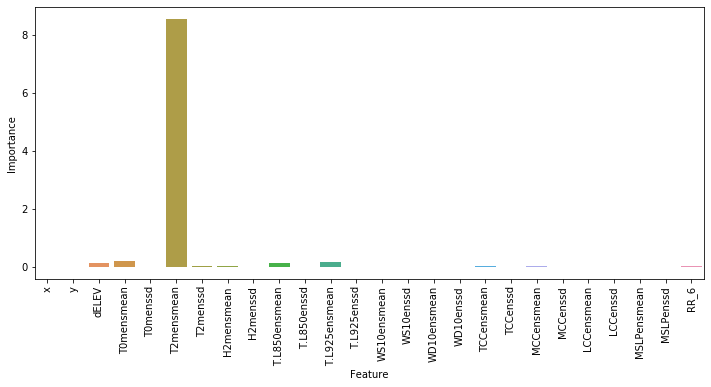

In [0]:
#fimp for fc
ref_score = fc_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0)

fimp_fc_standardized_model = perm_imp(fc_model)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_fc_standardized_model, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);


## Neural network (NN) model

In [0]:
#Neural network, one hidden layer

def build_hidden_model(n_features, n_outputs, hidden_nodes, compile=False,
                       optimizer='adam', lr=0.01, loss=crps_cost_function,
                       activation='relu'):
    """Build (and compile) a neural net with hidden layers
    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]
    inp = Input(shape=(n_features,))
    x = Dense(hidden_nodes[0], activation=activation)(inp)
    if len(hidden_nodes) > 1:
        for h in hidden_nodes[1:]:
            x = Dense(h, activation=activation)(x)
    x = Dense(n_outputs, activation='linear')(x)
    model = Model(inputs=inp, outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=loss)
    return model



In [0]:
input_features =  len(train_standardized_X[0])
print(input_features)
hidden_model = build_hidden_model(input_features, 2, hidden_nodes=[50], compile=True)
hidden_model.summary()

26
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 26)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                1350      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 102       
Total params: 1,452
Trainable params: 1,452
Non-trainable params: 0
_________________________________________________________________


In [0]:

hidden_model.compile( keras.optimizers.Adam(0.001), loss=crps_cost_function)

In [0]:
#Hidden model with distance to coast second run
%%time
hidden_model.fit(train_standardized_X, train_y, epochs=500, batch_size = 50,
                 validation_split=0.3, verbose=2, shuffle=False)

Train on 62597 samples, validate on 26828 samples
Epoch 1/500
 - 2s - loss: 1.9083 - val_loss: 1.0060
Epoch 2/500
 - 2s - loss: 0.9447 - val_loss: 0.9095
Epoch 3/500
 - 2s - loss: 0.8840 - val_loss: 0.8729
Epoch 4/500
 - 2s - loss: 0.8584 - val_loss: 0.8568
Epoch 5/500
 - 2s - loss: 0.8459 - val_loss: 0.8481
Epoch 6/500
 - 2s - loss: 0.8383 - val_loss: 0.8428
Epoch 7/500
 - 2s - loss: 0.8331 - val_loss: 0.8387
Epoch 8/500
 - 2s - loss: 0.8291 - val_loss: 0.8356
Epoch 9/500
 - 2s - loss: 0.8259 - val_loss: 0.8335
Epoch 10/500
 - 2s - loss: 0.8232 - val_loss: 0.8313
Epoch 11/500
 - 2s - loss: 0.8208 - val_loss: 0.8294
Epoch 12/500
 - 2s - loss: 0.8186 - val_loss: 0.8277
Epoch 13/500
 - 2s - loss: 0.8166 - val_loss: 0.8261
Epoch 14/500
 - 2s - loss: 0.8150 - val_loss: 0.8249
Epoch 15/500
 - 2s - loss: 0.8136 - val_loss: 0.8239
Epoch 16/500
 - 2s - loss: 0.8124 - val_loss: 0.8230
Epoch 17/500
 - 2s - loss: 0.8113 - val_loss: 0.8223
Epoch 18/500
 - 2s - loss: 0.8104 - val_loss: 0.8216
Epoch

In [0]:
#CRPS of train and test data 500 epochs ensemble mean and sd
(hidden_model.evaluate(train_std_df_X, train_y, batch_size = 50, verbose=0), hidden_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0))

(0.7890088468215171, 0.8033952380106306)

## Feature importance for NN model

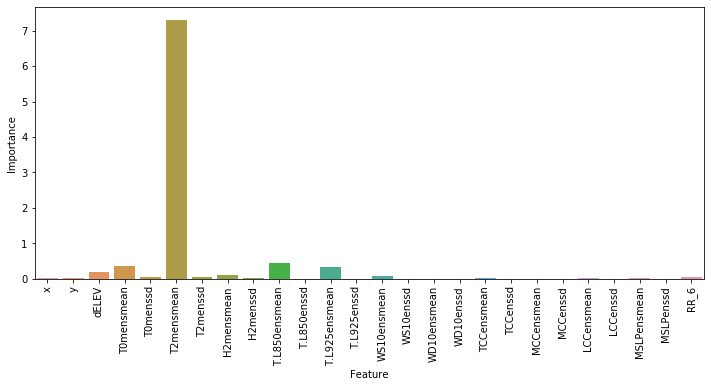

In [0]:
#fimp for nn with distance to coast 500 eposchs

ref_score = hidden_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0)
fimp_nn_standardized_model = perm_imp(hidden_model)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_nn_standardized_model, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## Feature importance tabular form for FC/LR and NN models

In [0]:
# Feature importance with distance to sea another run
comb_nn_df = pd.DataFrame(data=fimp_nn_standardized_model['Feature']); 
comb_nn_df['nn_std_importance'] = fimp_nn_standardized_model['Importance']
comb_nn_df.sort_values('nn_std_importance', ascending=False, inplace=True)
comb_nn_df['FC/LR_std_importance'] = fimp_fc_standardized_model['Importance']
comb_nn_df.head(30)

,Feature,nn_std_importance,FC/LR_std_importance
5,T2mensmean,7.294589,8.528208
9,T.L850ensmean,0.447305,0.126460
3,T0mensmean,0.354539,0.209848
11,T.L925ensmean,0.347389,0.145047
2,dELEV,0.202566,0.134191
7,H2mensmean,0.098765,0.034140
13,WS10ensmean,0.070620,0.002470
6,T2menssd,0.054949,0.034290
25,RR_6,0.054498,0.007640
4,T0menssd,0.043573,0.000974
